In [3]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
    try:
        GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    except:
        pass

    # for len_topN_1 in range(N-1,0,-1):
    for len_topN_1 in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)


'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[ii]
    bestID[subject] = np.where(t==max(t))[0][0]
chosenMask={}
for subject in bestID:
    # best ID  
    di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]+1}")
    chosenMask[subject] = di['bestROIs']

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask
for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
        np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)


'''
load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
''' 
def minimalClass(subject):
    '''
    purpose: 
        train offline models

    steps:
        load preprocessed and aligned behavior and brain data 
        select data with the wanted pattern like AB AC AD BC BD CD 
        train correspondng classifier and save the classifier performance and the classifiers themselves.

    '''

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import joblib
    import nibabel as nib
    import itertools
    from sklearn.linear_model import LogisticRegression

    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

    def jitter(size,const=0):
        jit = np.random.normal(0+const, 0.05, size)
        X = np.zeros((size))
        X = X + jit
        return X

    def other(target):
        other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
        return other_objs

    def red_vox(n_vox, prop=0.1):
        return int(np.ceil(n_vox * prop))

    def get_inds(X, Y, pair, testRun=None):

        inds = {}

        # return relative indices
        if testRun:
            trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
        else:
            trainIX = Y.index[(Y['label'].isin(pair))]

        # pull training and test data
        trainX = X[trainIX]
        trainY = Y.iloc[trainIX].label

        # Main classifier on 5 runs, testing on 6th
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)
        B = clf.coef_[0]  # pull betas

        # retrieve only the first object, then only the second object
        if testRun:
            obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
            obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
        else:
            obj1IX = Y.index[(Y['label'] == pair[0])]
            obj2IX = Y.index[(Y['label'] == pair[1])]

        # Get the average of the first object, then the second object
        obj1X = np.mean(X[obj1IX], 0)
        obj2X = np.mean(X[obj2IX], 0)

        # Build the importance map
        mult1X = obj1X * B
        mult2X = obj2X * B

        # Sort these so that they are from least to most important for a given category.
        sortmult1X = mult1X.argsort()[::-1]
        sortmult2X = mult2X.argsort()

        # add to a dictionary for later use
        inds[clf.classes_[0]] = sortmult1X
        inds[clf.classes_[1]] = sortmult2X

        return inds

    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    objects = ['bed', 'bench', 'chair', 'table']


    if dataSource == "neurosketch":
        funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
    elif dataSource == "realtime":
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
        anat = "$TO_BE_FILLED"
    else:
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "$TO_BE_FILLED"

    # print('mask dimensions: {}'. format(mask.shape))
    # print('number of voxels in mask: {}'.format(np.sum(mask)))
    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    # Compile preprocessed data and corresponding indices
    metas = []
    for run in range(1, 7):
        print(run, end='--')
        # retrieve from the dictionary which phase it is, assign the session
        phase = phasedict[run]
        
        # Build the path for the preprocessed functional data
        this4d = funcdata.format(run=run, phase=phase, sub=subject)
        
        # Read in the metadata, and reduce it to only the TR values from this run, add to a list
        thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
        if dataSource == "neurosketch":
            _run = 1 if run % 2 == 0 else 2
        else:
            _run = run
        thismeta = thismeta[thismeta['run_num'] == int(_run)]
        
        if dataSource == "realtime":
            TR_num = list(thismeta.TR.astype(int))
            labels = list(thismeta.Item)
            labels = [imcodeDict[label] for label in labels]
        else:
            TR_num = list(thismeta.TR_num.astype(int))
            labels = list(thismeta.label)
        
        print("LENGTH OF TR: {}".format(len(TR_num)))
        # Load the functional data
        runIm = nib.load(this4d)
        affine_mat = runIm.affine
        runImDat = runIm.get_fdata()
        
        # Use the TR numbers to select the correct features
        features = [runImDat[:,:,:,n+3] for n in TR_num]
        features = np.array(features)
        features = features[:, chosenMask==1]
        print("shape of features", features.shape, "shape of mask", mask.shape)
        # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
        # features = features - featmean
        # features = features - features.mean(0)
        features = normalize(features)
    #     features = np.expand_dims(features, 0)
        
        # Append both so we can use it later
    #     metas.append(labels)
    #     metas['label']

        t=pd.DataFrame()
        t['label']=labels
        t["run_num"]=run
        behav_data=t if run==1 else pd.concat([behav_data,t])
        
        runs = features if run == 1 else np.concatenate((runs, features))

    dimsize = runIm.header.get_zooms()
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}

    # Which run to use as test data (leave as None to not have test data)
    testRun = 6 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

    # Decide on the proportion of crescent data to use for classification
    include = 1
    objects = ['bed', 'bench', 'chair', 'table']
    allpairs = itertools.combinations(objects,2)
    accs={}
    # Iterate over all the possible target pairs of objects
    for pair in allpairs:
        # Find the control (remaining) objects for this pair
        altpair = other(pair)

        # pull sorted indices for each of the critical objects, in order of importance (low to high)
        # inds = get_inds(FEAT, META, pair, testRun=testRun)

        # Find the number of voxels that will be left given your inclusion parameter above
        # nvox = red_vox(FEAT.shape[1], include)

        for obj in pair:
            # foil = [i for i in pair if i != obj][0]
            for altobj in altpair:

                # establish a naming convention where it is $TARGET_$CLASSIFICATION
                # Target is the NF pair (e.g. bed/bench)
                # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

                # Pull the relevant inds from your previously established dictionary 
                # obj_inds = inds[obj]

                # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                # if testRun:
                #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                # else:
                #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
                #     testIX = META.index[(META['label'].isin([obj, altobj]))]
                # # pull training and test data
                # trainX = FEAT[trainIX]
                # testX = FEAT[testIX]
                # trainY = META.iloc[trainIX].label
                # testY = META.iloc[testIX].label

                # print(f"obj={obj},altobj={altobj}")
                # print(f"unique(trainY)={np.unique(trainY)}")
                # print(f"unique(testY)={np.unique(testY)}")
                # assert len(np.unique(trainY))==2

                # for testRun in range(6):
                if testRun:
                    trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                    testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
                else:
                    trainIX = ((META['label']==obj) + (META['label']==altobj))
                    testIX = ((META['label']==obj) + (META['label']==altobj))
                # pull training and test data
                trainX = FEAT[trainIX]
                testX = FEAT[testIX]
                trainY = META.iloc[np.asarray(trainIX)].label
                testY = META.iloc[np.asarray(testIX)].label

                print(f"obj={obj},altobj={altobj}")
                print(f"unique(trainY)={np.unique(trainY)}")
                print(f"unique(testY)={np.unique(testY)}")
                assert len(np.unique(trainY))==2

                # # If you're selecting high-importance features, this bit handles that
                # if include < 1:
                #     trainX = trainX[:, obj_inds[-nvox:]]
                #     testX = testX[:, obj_inds[-nvox:]]

                # Train your classifier
                clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                        multi_class='multinomial').fit(trainX, trainY)


                model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
                mkdir(model_folder)
                # Save it for later use
                joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))

                # Monitor progress by printing accuracy (only useful if you're running a test set)
                acc = clf.score(testX, testY)
                print(naming, acc)
                accs[naming]=acc
    
    # _=plt.figure()
    # _=plt.hist(list(accs.values()))
    return accs 

# sub_id=7
import sys

subject= '0119173' #sys.argv[1]
sub_id = [i for i,x in enumerate(subjects) if x == subject][0]

print("best 4way classifier accuracy = ",GreedyBestAcc[sub_id][bestID[subjects[sub_id]]])

accs = minimalClass(subject)
for acc in accs:
    print(acc,accs[acc])



'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []
    # for run in range(1, 7):
    #     print(run, end='--')
    #     # retrieve from the dictionary which phase it is, assign the session
    #     phase = phasedict[run]
    #     ses = 1
        
    #     # Build the path for the preprocessed functional data
    #     this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
        
    #     # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    #     thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    #     if dataSource == "neurosketch":
    #         _run = 1 if run % 2 == 0 else 2
    #     else:
    #         _run = run
    #     thismeta = thismeta[thismeta['run_num'] == int(_run)]
        
    #     if dataSource == "realtime":
    #         TR_num = list(thismeta.TR.astype(int))
    #         labels = list(thismeta.Item)
    #         labels = [imcodeDict[label] for label in labels]
    #     else:
    #         TR_num = list(thismeta.TR_num.astype(int))
    #         labels = list(thismeta.label)
        
    #     print("LENGTH OF TR: {}".format(len(TR_num)))
    #     # Load the functional data
    #     runIm = nib.load(this4d)
    #     affine_mat = runIm.affine
    #     runImDat = runIm.get_fdata()
        
    #     # Use the TR numbers to select the correct features
    #     features = [runImDat[:,:,:,n+3] for n in TR_num]
    #     features = np.array(features)
    #     chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    #     features = features[:, chosenMask==1]
    #     print("shape of features", features.shape, "shape of mask", mask.shape)
    #     # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    #     # features = features - featmean
    #     # features = features - features.mean(0)
    #     features = normalize(features)
    #     # features = np.expand_dims(features, 0)
        
    #     # Append both so we can use it later
    #     # metas.append(labels)
    #     # metas['label']

    #     t=pd.DataFrame()
    #     t['label']=labels
    #     t["run_num"]=run
    #     behav_data=t if run==1 else pd.concat([behav_data,t])
        
    #     runs = features if run == 1 else np.concatenate((runs, features))
    # for run in range(1, 7):
    run=6
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # print('mask dimensions: {}'. format(mask.shape))
    # print('number of voxels in mask: {}'.format(np.sum(mask)))

    # runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
    # actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]

    # objects = ['bed', 'bench', 'chair', 'table']

    # for ii,run in enumerate(actualRuns[:2]): # load behavior and brain data for current session
    #     t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    #     # mask = nib.load(f"{cfg.chosenMask}").get_data()
    #     mask = np.load(cfg.chosenMask)
    #     t = t[:,mask==1]
    #     t = normalize(t)
    #     brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    #     t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    #     behav_data=t if ii==0 else pd.concat([behav_data,t])

    # FEAT=brain_data.reshape(brain_data.shape[0],-1)
    # # FEAT_mean=np.mean(FEAT,axis=1)
    # # FEAT=(FEAT.T-FEAT_mean).T
    # # FEAT_mean=np.mean(FEAT,axis=0)
    # # FEAT=FEAT-FEAT_mean

    # META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}
    # label=[]
    # for curr_trial in range(META.shape[0]):
    #     label.append(imcodeDict[META['Item'].iloc[curr_trial]])
    # META['label']=label # merge the label column with the data dataframe


    # def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
    #     # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
    #     targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
    #     # Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
    #     Evidence=(X@clf.coef_.T+clf.intercept_) if targetID[0]==1 else (-(X@clf.coef_.T+clf.intercept_))
    #     Evidence = 1/(1+np.exp(-Evidence))
    #     return np.asarray(Evidence)

    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y[0])*1==1)[0][0]
    #     p = clf.predict_proba(X)[:,ID]
    #     BX=np.log(p/(1-p))
    #     return BX

    def classifierEvidence(clf,X,Y):
        ID=np.where((clf.classes_==Y[0])*1==1)[0][0]
        Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
        # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
        return np.asarray(Evidence)

    A_ID = (META['label']=='bed')
    X = FEAT[A_ID]

    # evidence_floor is C evidence for AC_CD BC_CD CD_CD classifier(can also be D evidence for CD classifier)
    # Y = ['table'] * X.shape[0]
    # CD_clf=joblib.load(cfg.usingModel_dir +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    # evidence_floor = np.mean(CD_C_evidence)
    # print(f"evidence_floor={evidence_floor}")

    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"

    # #try out other forms of floor: C evidence in AC and D evidence for AD
    # Y = ['bench'] * X.shape[0]
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_D_evidence = classifierEvidence(AD_clf,X,Y)
    # evidence_floor = np.mean(AD_D_evidence)
    # print(f"evidence_floor2={np.mean(evidence_floor)}")



    # # floor
    # Y = ['bench'] * X.shape[0]
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_D_evidence = classifierEvidence(CD_clf,X,Y)
    # evidence_floor = np.mean(CD_D_evidence)
    # print(f"evidence_floor={evidence_floor}")

    # Y = ['table'] * X.shape[0]
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    # evidence_floor = np.mean(CD_C_evidence)
    # print(f"evidence_floor={evidence_floor}")


    # # evidence_ceil  is A evidence in AC and AD classifier
    # Y = ['bed'] * X.shape[0]
    # AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    # AC_A_evidence = classifierEvidence(AC_clf,X,Y)
    # evidence_ceil1 = AC_A_evidence
    # print(f"evidence_ceil1={np.mean(evidence_ceil1)}")

    # Y = ['bed'] * X.shape[0]
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_A_evidence = classifierEvidence(AD_clf,X,Y)
    # evidence_ceil2 = AD_A_evidence
    # print(f"evidence_ceil2={np.mean(evidence_ceil2)}")

    # # evidence_ceil = np.mean(evidence_ceil1)
    # # evidence_ceil = np.mean(evidence_ceil2)
    # evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    # print(f"evidence_ceil={evidence_ceil}")
    store="\n"
    print("floor")
    # D evidence for AD_clf when A is presented.
    Y = ['bench'] * X.shape[0]
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_D_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_floor = np.mean(AD_D_evidence)
    print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # C evidence for AC_clf when A is presented.
    Y = ['table'] * X.shape[0]
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_C_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_floor = np.mean(AC_C_evidence)
    print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # D evidence for CD_clf when A is presented.
    Y = ['bench'] * X.shape[0]
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_D_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor = np.mean(CD_D_evidence)
    print(f"D evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor}"

    # C evidence for CD_clf when A is presented.
    Y = ['table'] * X.shape[0]
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor = np.mean(CD_C_evidence)
    print(f"C evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor}"




    print("ceil")
    store=store+"\n"+"ceil"
    # evidence_ceil  is A evidence in AC and AD classifier
    Y = ['bed'] * X.shape[0]
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_A_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_ceil1 = AC_A_evidence
    print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    Y = ['bed'] * X.shape[0]
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_A_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_ceil2 = AD_A_evidence
    print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # evidence_ceil = np.mean(evidence_ceil1)
    # evidence_ceil = np.mean(evidence_ceil2)
    evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    print(f"evidence_ceil={evidence_ceil}")
    store=store+"\n"+f"evidence_ceil={evidence_ceil}"

    return evidence_floor, evidence_ceil,store
    
floor, ceil,store = morphingTarget(subject)
mu = (ceil+floor)/2
sig = (ceil-floor)/2.3548
print(f"floor={floor}, ceil={ceil}")
print(f"mu={mu}, sig={sig}")

store=store+"\n"+f"floor={floor}, ceil={ceil}"
store=store+"\n"+f"mu={mu}, sig={sig}"

save_obj(store,f"./{subject}store")








# # floorCeilNeurosketch_child.sh
# #!/usr/bin/env bash
# # Input python command to be submitted as a job
# #SBATCH --output=logs/floorCeil-%j.out
# #SBATCH --job-name floorCeil
# #SBATCH --partition=short,day,scavenge,verylong
# #SBATCH --time=1:00:00 #20:00:00
# #SBATCH -n 5

# # Set up the environment

# subject=$1

# echo source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
# source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud

# python -u ./floorCeilNeurosketch.py $subject




# # floorCeilNeurosketch_parent.sh
# subjects="1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172" #these subjects are done with the batchRegions code
# for sub in $subjects
# do
#   for num in 25; #best ID is 30 thus the best num is 31
#   do
#     echo sbatch --requeue floorCeilNeurosketch_child.sh $sub
#     sbatch --requeue floorCeilNeurosketch_child.sh $sub
#   done
# done


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


best 4way classifier accuracy =  0.33125
1--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of mask (94, 94, 72)
(480, 3294)
(480, 2)
FEAT.shape=(480, 3294)
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
bedbench_bedchair 0.4
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']
bedbench_bedtable 0.525
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in P

bedbench_benchchair 0.4
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
bedbench_benchtable 0.525
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
bedchair_bedbench 0.525
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']
bedchair_bedtable 0.525
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedchair_chairbench 0.4
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
bedchair_chairtable 0.575
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
bedtable_bedbench 0.525
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
bedtable_bedchair 0.4
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedtable_tablebench 0.525
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
bedtable_tablechair 0.575
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
benchchair_benchbed 0.525
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
benchchair_benchtable 0.525
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchchair_chairbed 0.4
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
benchchair_chairtable 0.575
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
benchtable_benchbed 0.525
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchtable_benchchair 0.4
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']
benchtable_tablebed 0.525
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
benchtable_tablechair 0.575
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
chairtable_chairbed 0.4
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

chairtable_chairbench 0.4
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']
chairtable_tablebed 0.525
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
chairtable_tablebench 0.525
bedbench_bedchair 0.4
bedbench_bedtable 0.525
bedbench_benchchair 0.4
bedbench_benchtable 0.525
bedchair_bedbench 0.525
bedchair_bedtable 0.525
bedchair_chairbench 0.4
bedchair_chairtable 0.575
bedtable_bedbench 0.525
bedtable_bedchair 0.4
bedtable_tablebench 0.525
bedtable_tablechair 0.575
benchchair_benchbed 0.525
benchchair_benchtable 0.525
benchchair_chairbed 0.4
benchchair_chairtable 0.575
benchtable_benchbed 0.525
benchtable_benchchair 0.4
benchtable_tablebed 0.525
benchtable_tablechair 0.575
chairtable_chairbed 0.4
chairtable_chairbench 0.4
chairtable_tablebed 0.525
chairtable_tablebench 0.525
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

shape of features (80, 3294) shape of mask (94, 94, 72)
(80, 3294)
(80, 2)
FEAT.shape=(80, 3294)
floor
D evidence for AD_clf when A is presented=0.09611002790878051
C evidence for AC_clf when A is presented=0.01611887860304127
D evidence for CD_clf when A is presented=0.08364229206292774
C evidence for CD_clf when A is presented=-0.08364229206292774
ceil
A evidence in AC_clf when A is presented=-0.01611887860304127
A evidence in AD_clf when A is presented=-0.09611002790878051
evidence_ceil=-0.05611445325591089
floor=-0.08364229206292774, ceil=-0.05611445325591089
mu=-0.06987837265941932, sig=0.011690096316891815


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


6--LENGTH OF TR: 80
shape of features (80, 4954) shape of mask (94, 94, 72)
(80, 4954)
(80, 2)
FEAT.shape=(80, 4954)
floor
D evidence for AD_clf when A is presented=-0.3656890069421901
C evidence for AC_clf when A is presented=0.13161776964988006
D evidence for CD_clf when A is presented=-0.5280259552662404
C evidence for CD_clf when A is presented=0.5280259552662404
ceil
A evidence in AC_clf when A is presented=-0.13161776964988006
A evidence in AD_clf when A is presented=0.3656890069421901
evidence_ceil=0.11703561864615504
floor=0.5280259552662404, ceil=0.11703561864615504
mu=0.32253078695619775, sig=-0.17453301198406887


In [4]:
# '''
# 这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
# 这个code的运行逻辑是
# 用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
# '''


# '''
# purpose:
#     find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
#     train all possible pairs of 2way classifiers and save for evidence calculation
#     load saved classifiers and calculate different forms of evidence
# steps:
#     load the result of aggregate_greedy.py
#     display the result of aggregate_greedy.py
#     find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
#     load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
#     calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

# '''




# '''
# load the result of aggregate_greedy.py
# '''
# # To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
# import os
# os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
# from glob import glob
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import pickle5 as pickle
# import subprocess
# import numpy as np
# import os
# print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
# import numpy as np
# import nibabel as nib
# import sys
# import time
# import pandas as pd
# from sklearn.linear_model import LogisticRegression
# import itertools
# import pickle
# import subprocess
# from subprocess import call
# workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

# def save_obj(obj, name):
#     with open(name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
# def load_obj(name):
#     with open(name + '.pkl', 'rb') as f:
#         return pickle.load(f)
# roiloc="schaefer2018"
# dataSource="neurosketch"
# subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
# subjects=subjects_correctly_aligned
# N=25
# workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
# GreedyBestAcc=np.zeros((len(subjects),N+1))
# GreedyBestAcc[GreedyBestAcc==0]=None
# for ii,subject in enumerate(subjects):
#     try:
#         GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
#     except:
#         pass

#     # for len_topN_1 in range(N-1,0,-1):
#     for len_topN_1 in range(1,N):
#         # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
#         try:
#             di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
#             GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
#         except:
#             pass
# '''
# display the result of aggregate_greedy.py
# '''
# # GreedyBestAcc=GreedyBestAcc.T
# # plt.imshow(GreedyBestAcc)
# # _=plt.figure()
# # for i in range(GreedyBestAcc.shape[0]):
# #     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# # plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # # plt.ylim([0.19,0.36])
# # # plt.xlabel("number of ROIs")
# # # plt.ylabel("accuracy")
# # _=plt.figure()
# # for j in range(GreedyBestAcc.shape[1]):
# #     plt.plot(GreedyBestAcc[:,j])


# # GreedyBestAcc=GreedyBestAcc.T
# # _=plt.figure()
# # plt.imshow(GreedyBestAcc)


# '''
# find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
# '''
# #find best ID for each subject
# bestID={}
# for ii,subject in enumerate(subjects):
#     t=GreedyBestAcc[ii]
#     bestID[subject] = np.where(t==max(t))[0][0]
# chosenMask={}
# for subject in bestID:
#     # best ID  
#     di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]+1}")
#     chosenMask[subject] = di['bestROIs']

# def getMask(topN, subject):
#     workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
#     for pn, parc in enumerate(topN):
#         _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
#         aff = _mask.affine
#         _mask = _mask.get_data()
#         _mask = _mask.astype(int)
#         # say some things about the mask.
#         mask = _mask if pn == 0 else mask + _mask
#         mask[mask>0] = 1
#     return mask
# for sub in chosenMask:
#     mask=getMask(chosenMask[sub], sub)
#     if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
#         np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

# from scipy.stats import zscore
# def normalize(X):
#     _X=X.copy()
#     _X = zscore(_X, axis=0)
#     _X[np.isnan(_X)]=0
#     return _X

# def mkdir(folder):
#     if not os.path.isdir(folder):
#         os.mkdir(folder)


# '''
# load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
# ''' 
# # sub_id=7
# import sys

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]

# print("best 4way classifier accuracy = ",GreedyBestAcc[sub_id][bestID[subjects[sub_id]]])

# # accs = minimalClass(subject)

# '''
# purpose: 
#     train offline models

# steps:
#     load preprocessed and aligned behavior and brain data 
#     select data with the wanted pattern like AB AC AD BC BD CD 
#     train correspondng classifier and save the classifier performance and the classifiers themselves.

# '''

# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import sklearn
# import joblib
# import nibabel as nib
# import itertools
# from sklearn.linear_model import LogisticRegression

# def gaussian(x, mu, sig):
#     # mu and sig is determined before each neurofeedback session using 2 recognition runs.
#     return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

# def jitter(size,const=0):
#     jit = np.random.normal(0+const, 0.05, size)
#     X = np.zeros((size))
#     X = X + jit
#     return X

# def other(target):
#     other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
#     return other_objs

# def red_vox(n_vox, prop=0.1):
#     return int(np.ceil(n_vox * prop))

# def get_inds(X, Y, pair, testRun=None):

#     inds = {}

#     # return relative indices
#     if testRun:
#         trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
#     else:
#         trainIX = Y.index[(Y['label'].isin(pair))]

#     # pull training and test data
#     trainX = X[trainIX]
#     trainY = Y.iloc[trainIX].label

#     # Main classifier on 5 runs, testing on 6th
#     clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
#                             multi_class='multinomial').fit(trainX, trainY)
#     B = clf.coef_[0]  # pull betas

#     # retrieve only the first object, then only the second object
#     if testRun:
#         obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
#         obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
#     else:
#         obj1IX = Y.index[(Y['label'] == pair[0])]
#         obj2IX = Y.index[(Y['label'] == pair[1])]

#     # Get the average of the first object, then the second object
#     obj1X = np.mean(X[obj1IX], 0)
#     obj2X = np.mean(X[obj2IX], 0)

#     # Build the importance map
#     mult1X = obj1X * B
#     mult2X = obj2X * B

#     # Sort these so that they are from least to most important for a given category.
#     sortmult1X = mult1X.argsort()[::-1]
#     sortmult2X = mult2X.argsort()

#     # add to a dictionary for later use
#     inds[clf.classes_[0]] = sortmult1X
#     inds[clf.classes_[1]] = sortmult2X

#     return inds

# if 'milgram' in os.getcwd():
#     main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
# else:
#     main_dir='/Users/kailong/Desktop/rtTest'

# working_dir=main_dir
# os.chdir(working_dir)

# objects = ['bed', 'bench', 'chair', 'table']


# if dataSource == "neurosketch":
#     funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
#     metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
#     anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
# elif dataSource == "realtime":
#     funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
#     metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
#     anat = "$TO_BE_FILLED"
# else:
#     funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
#     metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
#     anat = "$TO_BE_FILLED"

# # print('mask dimensions: {}'. format(mask.shape))
# # print('number of voxels in mask: {}'.format(np.sum(mask)))
# phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
# imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
# chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
# # Compile preprocessed data and corresponding indices
# metas = []
# for run in range(1, 7):
#     print(run, end='--')
#     # retrieve from the dictionary which phase it is, assign the session
#     phase = phasedict[run]

#     # Build the path for the preprocessed functional data
#     this4d = funcdata.format(run=run, phase=phase, sub=subject)

#     # Read in the metadata, and reduce it to only the TR values from this run, add to a list
#     thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
#     if dataSource == "neurosketch":
#         _run = 1 if run % 2 == 0 else 2
#     else:
#         _run = run
#     thismeta = thismeta[thismeta['run_num'] == int(_run)]

#     if dataSource == "realtime":
#         TR_num = list(thismeta.TR.astype(int))
#         labels = list(thismeta.Item)
#         labels = [imcodeDict[label] for label in labels]
#     else:
#         TR_num = list(thismeta.TR_num.astype(int))
#         labels = list(thismeta.label)

#     print("LENGTH OF TR: {}".format(len(TR_num)))
#     # Load the functional data
#     runIm = nib.load(this4d)
#     affine_mat = runIm.affine
#     runImDat = runIm.get_fdata()

#     # Use the TR numbers to select the correct features
#     features = [runImDat[:,:,:,n+3] for n in TR_num]
#     features = np.array(features)
#     features = features[:, chosenMask==1]
#     print("shape of features", features.shape, "shape of mask", mask.shape)
#     # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
#     # features = features - featmean
#     # features = features - features.mean(0)
#     features = normalize(features)
# #     features = np.expand_dims(features, 0)

#     # Append both so we can use it later
# #     metas.append(labels)
# #     metas['label']

#     t=pd.DataFrame()
#     t['label']=labels
#     t["run_num"]=run
#     behav_data=t if run==1 else pd.concat([behav_data,t])

#     runs = features if run == 1 else np.concatenate((runs, features))

# dimsize = runIm.header.get_zooms()
# brain_data = runs
# print(brain_data.shape)
# print(behav_data.shape)
# FEAT=brain_data
# print(f"FEAT.shape={FEAT.shape}")
# META=behav_data

# # convert item colume to label colume
# imcodeDict={
# 'A': 'bed',
# 'B': 'chair',
# 'C': 'table',
# 'D': 'bench'}


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


best 4way classifier accuracy =  0.33125
1--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of mask (94, 94, 72)
(480, 3294)
(480, 2)
FEAT.shape=(480, 3294)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [23]:
behav_data

,label,run_num
0,bed,1
1,bench,1
2,chair,1
3,table,1
4,table,1
...,...,...
75,chair,6
76,chair,6
77,bench,6
78,table,6


In [26]:
# # def Class(data, bcvar):
# #     metas = bcvar[0]
# #     data4d = data[0]
# #     print(data4d.shape)
# def Class(brain_data,behav_data):
#     accs = []
#     for run in range(1,7):
#         trainIX = behav_data['run_num']==int(run)
#         testIX = behav_data['run_num']!=int(run)

#         trainX =  brain_data[trainIX]
#         trainY =  behav_data.iloc[np.asarray(trainIX)].label

#         testX =  brain_data[testIX]
#         testY =  behav_data.iloc[np.asarray(testIX)].label

#         clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
#                                  multi_class='multinomial').fit(trainX, trainY)

#         # Monitor progress by printing accuracy (only useful if you're running a test set)
#         acc = clf.score(testX, testY)
#         accs.append(acc)
#     accs
#     return np.mean(accs)
# accs=Class(brain_data,behav_data)
# accs

0.24791666666666667

In [27]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
    try:
        GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    except:
        pass

    # for len_topN_1 in range(N-1,0,-1):
    for len_topN_1 in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)


'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[ii]
    bestID[subject] = np.where(t==max(t))[0][0]
chosenMask={}
for subject in bestID:
    # best ID  
    di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]+1}")
    chosenMask[subject] = di['bestROIs']

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask
for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
        np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)


'''
load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
''' 
def minimalClass(subject):
    '''
    purpose: 
        train offline models

    steps:
        load preprocessed and aligned behavior and brain data 
        select data with the wanted pattern like AB AC AD BC BD CD 
        train correspondng classifier and save the classifier performance and the classifiers themselves.

    '''

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import joblib
    import nibabel as nib
    import itertools
    from sklearn.linear_model import LogisticRegression

    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

    def jitter(size,const=0):
        jit = np.random.normal(0+const, 0.05, size)
        X = np.zeros((size))
        X = X + jit
        return X

    def other(target):
        other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
        return other_objs

    def red_vox(n_vox, prop=0.1):
        return int(np.ceil(n_vox * prop))

    def get_inds(X, Y, pair, testRun=None):

        inds = {}

        # return relative indices
        if testRun:
            trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
        else:
            trainIX = Y.index[(Y['label'].isin(pair))]

        # pull training and test data
        trainX = X[trainIX]
        trainY = Y.iloc[trainIX].label

        # Main classifier on 5 runs, testing on 6th
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)
        B = clf.coef_[0]  # pull betas

        # retrieve only the first object, then only the second object
        if testRun:
            obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
            obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
        else:
            obj1IX = Y.index[(Y['label'] == pair[0])]
            obj2IX = Y.index[(Y['label'] == pair[1])]

        # Get the average of the first object, then the second object
        obj1X = np.mean(X[obj1IX], 0)
        obj2X = np.mean(X[obj2IX], 0)

        # Build the importance map
        mult1X = obj1X * B
        mult2X = obj2X * B

        # Sort these so that they are from least to most important for a given category.
        sortmult1X = mult1X.argsort()[::-1]
        sortmult2X = mult2X.argsort()

        # add to a dictionary for later use
        inds[clf.classes_[0]] = sortmult1X
        inds[clf.classes_[1]] = sortmult2X

        return inds

    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    objects = ['bed', 'bench', 'chair', 'table']


    if dataSource == "neurosketch":
        funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
    elif dataSource == "realtime":
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
        anat = "$TO_BE_FILLED"
    else:
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "$TO_BE_FILLED"

    # print('mask dimensions: {}'. format(mask.shape))
    # print('number of voxels in mask: {}'.format(np.sum(mask)))
    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    # Compile preprocessed data and corresponding indices
    metas = []
    for run in range(1, 7):
        print(run, end='--')
        # retrieve from the dictionary which phase it is, assign the session
        phase = phasedict[run]
        
        # Build the path for the preprocessed functional data
        this4d = funcdata.format(run=run, phase=phase, sub=subject)
        
        # Read in the metadata, and reduce it to only the TR values from this run, add to a list
        thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
        if dataSource == "neurosketch":
            _run = 1 if run % 2 == 0 else 2
        else:
            _run = run
        thismeta = thismeta[thismeta['run_num'] == int(_run)]
        
        if dataSource == "realtime":
            TR_num = list(thismeta.TR.astype(int))
            labels = list(thismeta.Item)
            labels = [imcodeDict[label] for label in labels]
        else:
            TR_num = list(thismeta.TR_num.astype(int))
            labels = list(thismeta.label)
        
        print("LENGTH OF TR: {}".format(len(TR_num)))
        # Load the functional data
        runIm = nib.load(this4d)
        affine_mat = runIm.affine
        runImDat = runIm.get_fdata()
        
        # Use the TR numbers to select the correct features
        features = [runImDat[:,:,:,n+3] for n in TR_num]
        features = np.array(features)
        features = features[:, chosenMask==1]
        print("shape of features", features.shape, "shape of mask", mask.shape)
        # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
        # features = features - featmean
        # features = features - features.mean(0)
        features = normalize(features)
    #     features = np.expand_dims(features, 0)
        
        # Append both so we can use it later
    #     metas.append(labels)
    #     metas['label']

        t=pd.DataFrame()
        t['label']=labels
        t["run_num"]=run
        behav_data=t if run==1 else pd.concat([behav_data,t])
        
        runs = features if run == 1 else np.concatenate((runs, features))

    dimsize = runIm.header.get_zooms()
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    def Class(brain_data,behav_data):
        accs = []
        for run in range(1,7):
            trainIX = behav_data['run_num']==int(run)
            testIX = behav_data['run_num']!=int(run)

            trainX =  brain_data[trainIX]
            trainY =  behav_data.iloc[np.asarray(trainIX)].label

            testX =  brain_data[testIX]
            testY =  behav_data.iloc[np.asarray(testIX)].label

            clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                    multi_class='multinomial').fit(trainX, trainY)

            # Monitor progress by printing accuracy (only useful if you're running a test set)
            acc = clf.score(testX, testY)
            accs.append(acc)
        accs
        return np.mean(accs)
    accs=Class(brain_data,behav_data)
    print(f"new trained 4 way classifier accuracy={accs}")


    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}

    # Which run to use as test data (leave as None to not have test data)
    testRun = 6 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

    # Decide on the proportion of crescent data to use for classification
    include = 1
    objects = ['bed', 'bench', 'chair', 'table']
    allpairs = itertools.combinations(objects,2)
    accs={}
    # Iterate over all the possible target pairs of objects
    for pair in allpairs:
        # Find the control (remaining) objects for this pair
        altpair = other(pair)

        # pull sorted indices for each of the critical objects, in order of importance (low to high)
        # inds = get_inds(FEAT, META, pair, testRun=testRun)

        # Find the number of voxels that will be left given your inclusion parameter above
        # nvox = red_vox(FEAT.shape[1], include)

        for obj in pair:
            # foil = [i for i in pair if i != obj][0]
            for altobj in altpair:

                # establish a naming convention where it is $TARGET_$CLASSIFICATION
                # Target is the NF pair (e.g. bed/bench)
                # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

                # Pull the relevant inds from your previously established dictionary 
                # obj_inds = inds[obj]

                # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                # if testRun:
                #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                # else:
                #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
                #     testIX = META.index[(META['label'].isin([obj, altobj]))]
                # # pull training and test data
                # trainX = FEAT[trainIX]
                # testX = FEAT[testIX]
                # trainY = META.iloc[trainIX].label
                # testY = META.iloc[testIX].label

                # print(f"obj={obj},altobj={altobj}")
                # print(f"unique(trainY)={np.unique(trainY)}")
                # print(f"unique(testY)={np.unique(testY)}")
                # assert len(np.unique(trainY))==2

                # for testRun in range(6):
                if testRun:
                    trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                    testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
                else:
                    trainIX = ((META['label']==obj) + (META['label']==altobj))
                    testIX = ((META['label']==obj) + (META['label']==altobj))
                # pull training and test data
                trainX = FEAT[trainIX]
                testX = FEAT[testIX]
                trainY = META.iloc[np.asarray(trainIX)].label
                testY = META.iloc[np.asarray(testIX)].label

                # print(f"obj={obj},altobj={altobj}")
                # print(f"unique(trainY)={np.unique(trainY)}")
                # print(f"unique(testY)={np.unique(testY)}")
                assert len(np.unique(trainY))==2

                # # If you're selecting high-importance features, this bit handles that
                # if include < 1:
                #     trainX = trainX[:, obj_inds[-nvox:]]
                #     testX = testX[:, obj_inds[-nvox:]]

                # Train your classifier
                clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                        multi_class='multinomial').fit(trainX, trainY)


                model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
                mkdir(model_folder)
                # Save it for later use
                joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))

                # Monitor progress by printing accuracy (only useful if you're running a test set)
                acc = clf.score(testX, testY)
                # print(naming, acc)
                accs[naming]=acc
    
    # _=plt.figure()
    # _=plt.hist(list(accs.values()))
    return accs 

# sub_id=7
import sys

subject= '0119173' #sys.argv[1]
sub_id = [i for i,x in enumerate(subjects) if x == subject][0]

print("best 4way classifier accuracy = ",GreedyBestAcc[sub_id][bestID[subjects[sub_id]]])

accs = minimalClass(subject)

for acc in accs:
    print(acc,accs[acc])



'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []
    # for run in range(1, 7):
    #     print(run, end='--')
    #     # retrieve from the dictionary which phase it is, assign the session
    #     phase = phasedict[run]
    #     ses = 1
        
    #     # Build the path for the preprocessed functional data
    #     this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
        
    #     # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    #     thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    #     if dataSource == "neurosketch":
    #         _run = 1 if run % 2 == 0 else 2
    #     else:
    #         _run = run
    #     thismeta = thismeta[thismeta['run_num'] == int(_run)]
        
    #     if dataSource == "realtime":
    #         TR_num = list(thismeta.TR.astype(int))
    #         labels = list(thismeta.Item)
    #         labels = [imcodeDict[label] for label in labels]
    #     else:
    #         TR_num = list(thismeta.TR_num.astype(int))
    #         labels = list(thismeta.label)
        
    #     print("LENGTH OF TR: {}".format(len(TR_num)))
    #     # Load the functional data
    #     runIm = nib.load(this4d)
    #     affine_mat = runIm.affine
    #     runImDat = runIm.get_fdata()
        
    #     # Use the TR numbers to select the correct features
    #     features = [runImDat[:,:,:,n+3] for n in TR_num]
    #     features = np.array(features)
    #     chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    #     features = features[:, chosenMask==1]
    #     print("shape of features", features.shape, "shape of mask", mask.shape)
    #     # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    #     # features = features - featmean
    #     # features = features - features.mean(0)
    #     features = normalize(features)
    #     # features = np.expand_dims(features, 0)
        
    #     # Append both so we can use it later
    #     # metas.append(labels)
    #     # metas['label']

    #     t=pd.DataFrame()
    #     t['label']=labels
    #     t["run_num"]=run
    #     behav_data=t if run==1 else pd.concat([behav_data,t])
        
    #     runs = features if run == 1 else np.concatenate((runs, features))
    # for run in range(1, 7):
    run=6
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # print('mask dimensions: {}'. format(mask.shape))
    # print('number of voxels in mask: {}'.format(np.sum(mask)))

    # runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
    # actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]

    # objects = ['bed', 'bench', 'chair', 'table']

    # for ii,run in enumerate(actualRuns[:2]): # load behavior and brain data for current session
    #     t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    #     # mask = nib.load(f"{cfg.chosenMask}").get_data()
    #     mask = np.load(cfg.chosenMask)
    #     t = t[:,mask==1]
    #     t = normalize(t)
    #     brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    #     t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    #     behav_data=t if ii==0 else pd.concat([behav_data,t])

    # FEAT=brain_data.reshape(brain_data.shape[0],-1)
    # # FEAT_mean=np.mean(FEAT,axis=1)
    # # FEAT=(FEAT.T-FEAT_mean).T
    # # FEAT_mean=np.mean(FEAT,axis=0)
    # # FEAT=FEAT-FEAT_mean

    # META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}
    # label=[]
    # for curr_trial in range(META.shape[0]):
    #     label.append(imcodeDict[META['Item'].iloc[curr_trial]])
    # META['label']=label # merge the label column with the data dataframe


    # def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
    #     # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
    #     targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
    #     # Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
    #     Evidence=(X@clf.coef_.T+clf.intercept_) if targetID[0]==1 else (-(X@clf.coef_.T+clf.intercept_))
    #     Evidence = 1/(1+np.exp(-Evidence))
    #     return np.asarray(Evidence)

    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y[0])*1==1)[0][0]
    #     p = clf.predict_proba(X)[:,ID]
    #     BX=np.log(p/(1-p))
    #     return BX

    def classifierEvidence(clf,X,Y):
        ID=np.where((clf.classes_==Y[0])*1==1)[0][0]
        Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
        # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
        return np.asarray(Evidence)

    A_ID = (META['label']=='bed')
    X = FEAT[A_ID]

    # evidence_floor is C evidence for AC_CD BC_CD CD_CD classifier(can also be D evidence for CD classifier)
    # Y = ['table'] * X.shape[0]
    # CD_clf=joblib.load(cfg.usingModel_dir +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    # evidence_floor = np.mean(CD_C_evidence)
    # print(f"evidence_floor={evidence_floor}")

    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"

    # #try out other forms of floor: C evidence in AC and D evidence for AD
    # Y = ['bench'] * X.shape[0]
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_D_evidence = classifierEvidence(AD_clf,X,Y)
    # evidence_floor = np.mean(AD_D_evidence)
    # print(f"evidence_floor2={np.mean(evidence_floor)}")



    # # floor
    # Y = ['bench'] * X.shape[0]
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_D_evidence = classifierEvidence(CD_clf,X,Y)
    # evidence_floor = np.mean(CD_D_evidence)
    # print(f"evidence_floor={evidence_floor}")

    # Y = ['table'] * X.shape[0]
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    # evidence_floor = np.mean(CD_C_evidence)
    # print(f"evidence_floor={evidence_floor}")


    # # evidence_ceil  is A evidence in AC and AD classifier
    # Y = ['bed'] * X.shape[0]
    # AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    # AC_A_evidence = classifierEvidence(AC_clf,X,Y)
    # evidence_ceil1 = AC_A_evidence
    # print(f"evidence_ceil1={np.mean(evidence_ceil1)}")

    # Y = ['bed'] * X.shape[0]
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_A_evidence = classifierEvidence(AD_clf,X,Y)
    # evidence_ceil2 = AD_A_evidence
    # print(f"evidence_ceil2={np.mean(evidence_ceil2)}")

    # # evidence_ceil = np.mean(evidence_ceil1)
    # # evidence_ceil = np.mean(evidence_ceil2)
    # evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    # print(f"evidence_ceil={evidence_ceil}")
    store="\n"
    print("floor")
    # D evidence for AD_clf when A is presented.
    Y = ['bench'] * X.shape[0]
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_D_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_floor = np.mean(AD_D_evidence)
    print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # C evidence for AC_clf when A is presented.
    Y = ['table'] * X.shape[0]
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_C_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_floor = np.mean(AC_C_evidence)
    print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # D evidence for CD_clf when A is presented.
    Y = ['bench'] * X.shape[0]
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_D_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor = np.mean(CD_D_evidence)
    print(f"D evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor}"

    # C evidence for CD_clf when A is presented.
    Y = ['table'] * X.shape[0]
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor = np.mean(CD_C_evidence)
    print(f"C evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor}"




    print("ceil")
    store=store+"\n"+"ceil"
    # evidence_ceil  is A evidence in AC and AD classifier
    Y = ['bed'] * X.shape[0]
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_A_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_ceil1 = AC_A_evidence
    print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    Y = ['bed'] * X.shape[0]
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_A_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_ceil2 = AD_A_evidence
    print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # evidence_ceil = np.mean(evidence_ceil1)
    # evidence_ceil = np.mean(evidence_ceil2)
    evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    print(f"evidence_ceil={evidence_ceil}")
    store=store+"\n"+f"evidence_ceil={evidence_ceil}"

    return evidence_floor, evidence_ceil,store
    
floor, ceil,store = morphingTarget(subject)
mu = (ceil+floor)/2
sig = (ceil-floor)/2.3548
print(f"floor={floor}, ceil={ceil}")
print(f"mu={mu}, sig={sig}")

store=store+"\n"+f"floor={floor}, ceil={ceil}"
store=store+"\n"+f"mu={mu}, sig={sig}"

save_obj(store,f"./{subject}store")








# # floorCeilNeurosketch_child.sh
# #!/usr/bin/env bash
# # Input python command to be submitted as a job
# #SBATCH --output=logs/floorCeil-%j.out
# #SBATCH --job-name floorCeil
# #SBATCH --partition=short,day,scavenge,verylong
# #SBATCH --time=1:00:00 #20:00:00
# #SBATCH --mem=10000
# #SBATCH -n 5

# # Set up the environment

# subject=$1

# echo source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
# source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud

# python -u ./floorCeilNeurosketch.py $subject




# # floorCeilNeurosketch_parent.sh
# subjects="1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172" #these subjects are done with the batchRegions code
# for sub in $subjects
# do
#   for num in 25; #best ID is 30 thus the best num is 31
#   do
#     echo sbatch --requeue floorCeilNeurosketch_child.sh $sub
#     sbatch --requeue floorCeilNeurosketch_child.sh $sub
#   done
# done


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


best 4way classifier accuracy =  0.33125
1--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of mask (94, 94, 72)
(480, 3294)
(480, 2)
FEAT.shape=(480, 3294)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


new trained 4 way classifier accuracy=0.24791666666666667


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_bedchair 0.4
bedbench_bedtable 0.525
bedbench_benchchair 0.4
bedbench_benchtable 0.525
bedchair_bedbench 0.525
bedchair_bedtable 0.525
bedchair_chairbench 0.4
bedchair_chairtable 0.575
bedtable_bedbench 0.525
bedtable_bedchair 0.4
bedtable_tablebench 0.525
bedtable_tablechair 0.575
benchchair_benchbed 0.525
benchchair_benchtable 0.525
benchchair_chairbed 0.4
benchchair_chairtable 0.575
benchtable_benchbed 0.525
benchtable_benchchair 0.4
benchtable_tablebed 0.525
benchtable_tablechair 0.575
chairtable_chairbed 0.4
chairtable_chairbench 0.4
chairtable_tablebed 0.525
chairtable_tablebench 0.525
6--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
(80, 3294)
(80, 2)
FEAT.shape=(80, 3294)
floor
D evidence for AD_clf when A is presented=0.09611002790878051
C evidence for AC_clf when A is presented=0.01611887860304127
D evidence for CD_clf when A is presented=0.08364229206292774
C evidence for CD_clf when A is presented=-0.08364229206292774
ceil
A evidence in A

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [91]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
for ii,subject in enumerate(subjects):
#     try:
#         GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
#     except:
#         pass
    t=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
#             GreedyBestAcc[ii,len_topN] = di['bestAcc']
            
        except:
            pass

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[subject]
    bestID[subject] = numberOfROIs[subject][np.where(t==np.nanmax(t))[0][0]] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


In [17]:

'''
to load the imtermediate results from greedy code to examine the system
'''
def wait(tmpFile):
    while not os.path.exists(tmpFile+'_result.npy'):
        time.sleep(5)
        print(f"waiting for {tmpFile}_result.npy\n")
    return np.load(tmpFile+'_result.npy')

subject= '0119173' #sys.argv[1]
sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
intermediate_result=np.zeros((N+1,N+1))
for i in range(N,1,-1):
    for j in range(i):
        tmpFile=f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
        sl_result=wait(tmpFile)
        intermediate_result[i,j]=sl_result



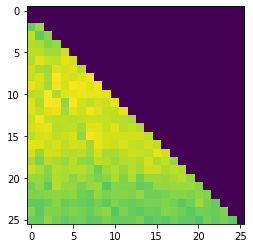

In [9]:
_=plt.imshow(intermediate_result)
#最后一行是25个24ROI，第2行是2个1ROI

In [26]:
print(np.max(intermediate_result))
print(np.where(intermediate_result==0.33125))
print(intermediate_result[11,2])
i,j=11,2
#i==2的时候ROI1，i==3的时候ROI2，i==11的时候ROI10

tmpFile=f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
np.load(tmpFile+'_result.npy')

0.33125
(array([11]), array([2]))
0.33125


array(0.33125)

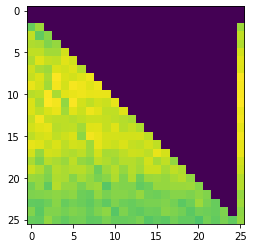

In [12]:
# for i in range(intermediate_result.shape[0]):
#     intermediate_result[i,-1]=np.max(intermediate_result[i])
# _=plt.imshow(intermediate_result)

In [34]:
for i in range(intermediate_result.shape[0]):
    print(np.max(intermediate_result[i]))


0.0
0.0
0.2833333333333334
0.3
0.2916666666666667
0.3083333333333333
0.31666666666666665
0.31458333333333327
0.32916666666666666
0.32708333333333334
0.32916666666666666
0.33125
0.32291666666666663
0.325
0.31875
0.32499999999999996
0.31875000000000003
0.3208333333333333
0.30833333333333335
0.3041666666666667
0.29375
0.29375
0.2791666666666666
0.2833333333333333
0.275
0.2770833333333333


In [81]:

di=load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{8}")
di

FileNotFoundError: [Errno 2] No such file or directory: './tmp_folder/0119173_25_schaefer2018_neurosketch_8.pkl'

In [75]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
    try:
        GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    except:
        pass

    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[ii,len_topN] = di['bestAcc']
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[ii]
    bestID[subject] = np.where(t==np.nanmax(t))[0][0] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask
for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    # if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
    np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)


'''
load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
''' 
def minimalClass(subject):
    '''
    purpose: 
        train offline models

    steps:
        load preprocessed and aligned behavior and brain data 
        select data with the wanted pattern like AB AC AD BC BD CD 
        train correspondng classifier and save the classifier performance and the classifiers themselves.

    '''

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import joblib
    import nibabel as nib
    import itertools
    from sklearn.linear_model import LogisticRegression

    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

    def jitter(size,const=0):
        jit = np.random.normal(0+const, 0.05, size)
        X = np.zeros((size))
        X = X + jit
        return X

    def other(target):
        other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
        return other_objs

    def red_vox(n_vox, prop=0.1):
        return int(np.ceil(n_vox * prop))

    def get_inds(X, Y, pair, testRun=None):

        inds = {}

        # return relative indices
        if testRun:
            trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
        else:
            trainIX = Y.index[(Y['label'].isin(pair))]

        # pull training and test data
        trainX = X[trainIX]
        trainY = Y.iloc[trainIX].label

        # Main classifier on 5 runs, testing on 6th
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)
        B = clf.coef_[0]  # pull betas

        # retrieve only the first object, then only the second object
        if testRun:
            obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
            obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
        else:
            obj1IX = Y.index[(Y['label'] == pair[0])]
            obj2IX = Y.index[(Y['label'] == pair[1])]

        # Get the average of the first object, then the second object
        obj1X = np.mean(X[obj1IX], 0)
        obj2X = np.mean(X[obj2IX], 0)

        # Build the importance map
        mult1X = obj1X * B
        mult2X = obj2X * B

        # Sort these so that they are from least to most important for a given category.
        sortmult1X = mult1X.argsort()[::-1]
        sortmult2X = mult2X.argsort()

        # add to a dictionary for later use
        inds[clf.classes_[0]] = sortmult1X
        inds[clf.classes_[1]] = sortmult2X

        return inds

    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    objects = ['bed', 'bench', 'chair', 'table']


    if dataSource == "neurosketch":
        funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
    elif dataSource == "realtime":
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
        anat = "$TO_BE_FILLED"
    else:
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "$TO_BE_FILLED"

    # print('mask dimensions: {}'. format(mask.shape))
    # print('number of voxels in mask: {}'.format(np.sum(mask)))
    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    print(f"np.sum(chosenMask)={np.sum(chosenMask)}")
    # Compile preprocessed data and corresponding indices
    metas = []
    for run in range(1, 7):
        print(run, end='--')
        # retrieve from the dictionary which phase it is, assign the session
        phase = phasedict[run]
        
        # Build the path for the preprocessed functional data
        this4d = funcdata.format(run=run, phase=phase, sub=subject)
        
        # Read in the metadata, and reduce it to only the TR values from this run, add to a list
        thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
        if dataSource == "neurosketch":
            _run = 1 if run % 2 == 0 else 2
        else:
            _run = run
        thismeta = thismeta[thismeta['run_num'] == int(_run)]
        
        if dataSource == "realtime":
            TR_num = list(thismeta.TR.astype(int))
            labels = list(thismeta.Item)
            labels = [imcodeDict[label] for label in labels]
        else:
            TR_num = list(thismeta.TR_num.astype(int))
            labels = list(thismeta.label)
        
        print("LENGTH OF TR: {}".format(len(TR_num)))
        # Load the functional data
        runIm = nib.load(this4d)
        affine_mat = runIm.affine
        runImDat = runIm.get_fdata()
        
        # Use the TR numbers to select the correct features
        features = [runImDat[:,:,:,n+3] for n in TR_num] # here shape is from (94, 94, 72, 240) to (80, 94, 94, 72)
        features = np.array(features)
        features = features[:, chosenMask==1]
        print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
        features = normalize(features)
        # features = np.expand_dims(features, 0)
        
        # Append both so we can use it later
        # metas.append(labels)
        # metas['label']

        t=pd.DataFrame()
        t['label']=labels
        t["run_num"]=run
        behav_data=t if run==1 else pd.concat([behav_data,t])
        
        runs = features if run == 1 else np.concatenate((runs, features))

    dimsize = runIm.header.get_zooms()
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    def Class(brain_data,behav_data):
        accs = []
        for run in range(1,7):
            trainIX = behav_data['run_num']!=int(run)
            testIX = behav_data['run_num']==int(run)

            trainX =  brain_data[trainIX]
            trainY =  behav_data.iloc[np.asarray(trainIX)].label

            testX =  brain_data[testIX]
            testY =  behav_data.iloc[np.asarray(testIX)].label

            clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                    multi_class='multinomial').fit(trainX, trainY)

            # Monitor progress by printing accuracy (only useful if you're running a test set)
            acc = clf.score(testX, testY)
            accs.append(acc)
        accs
        return np.mean(accs)
    accs=Class(brain_data,behav_data)
    print(f"new trained 4 way classifier accuracy={accs}")


    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}

    # Which run to use as test data (leave as None to not have test data)
    testRun = 6 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

    # Decide on the proportion of crescent data to use for classification
    include = 1
    objects = ['bed', 'bench', 'chair', 'table']
    allpairs = itertools.combinations(objects,2)
    accs={}
    # Iterate over all the possible target pairs of objects
    for pair in allpairs:
        # Find the control (remaining) objects for this pair
        altpair = other(pair)

        # pull sorted indices for each of the critical objects, in order of importance (low to high)
        # inds = get_inds(FEAT, META, pair, testRun=testRun)

        # Find the number of voxels that will be left given your inclusion parameter above
        # nvox = red_vox(FEAT.shape[1], include)

        for obj in pair:
            # foil = [i for i in pair if i != obj][0]
            for altobj in altpair:

                # establish a naming convention where it is $TARGET_$CLASSIFICATION
                # Target is the NF pair (e.g. bed/bench)
                # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

                # Pull the relevant inds from your previously established dictionary 
                # obj_inds = inds[obj]

                # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                # if testRun:
                #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                # else:
                #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
                #     testIX = META.index[(META['label'].isin([obj, altobj]))]
                # # pull training and test data
                # trainX = FEAT[trainIX]
                # testX = FEAT[testIX]
                # trainY = META.iloc[trainIX].label
                # testY = META.iloc[testIX].label

                # print(f"obj={obj},altobj={altobj}")
                # print(f"unique(trainY)={np.unique(trainY)}")
                # print(f"unique(testY)={np.unique(testY)}")
                # assert len(np.unique(trainY))==2

                # for testRun in range(6):
                if testRun:
                    trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                    testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
                else:
                    trainIX = ((META['label']==obj) + (META['label']==altobj))
                    testIX = ((META['label']==obj) + (META['label']==altobj))
                # pull training and test data
                trainX = FEAT[trainIX]
                testX = FEAT[testIX]
                trainY = META.iloc[np.asarray(trainIX)].label
                testY = META.iloc[np.asarray(testIX)].label

                # print(f"obj={obj},altobj={altobj}")
                # print(f"unique(trainY)={np.unique(trainY)}")
                # print(f"unique(testY)={np.unique(testY)}")
                assert len(np.unique(trainY))==2

                # # If you're selecting high-importance features, this bit handles that
                # if include < 1:
                #     trainX = trainX[:, obj_inds[-nvox:]]
                #     testX = testX[:, obj_inds[-nvox:]]

                # Train your classifier
                clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                        multi_class='multinomial').fit(trainX, trainY)


                model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
                mkdir(model_folder)
                # Save it for later use
                joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))

                # Monitor progress by printing accuracy (only useful if you're running a test set)
                acc = clf.score(testX, testY)
                # print(naming, acc)
                accs[naming]=acc
    
    # _=plt.figure()
    # _=plt.hist(list(accs.values()))
    return accs 

# sub_id=7
import sys

subject= '0119173' #sys.argv[1]
sub_id = [i for i,x in enumerate(subjects) if x == subject][0]

print("best 4way classifier accuracy = ",GreedyBestAcc[sub_id][bestID[subjects[sub_id]]])

accs = minimalClass(subject)

for acc in accs:
    print(acc,accs[acc])



'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []
    # for run in range(1, 7):
    #     print(run, end='--')
    #     # retrieve from the dictionary which phase it is, assign the session
    #     phase = phasedict[run]
    #     ses = 1
        
    #     # Build the path for the preprocessed functional data
    #     this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
        
    #     # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    #     thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    #     if dataSource == "neurosketch":
    #         _run = 1 if run % 2 == 0 else 2
    #     else:
    #         _run = run
    #     thismeta = thismeta[thismeta['run_num'] == int(_run)]
        
    #     if dataSource == "realtime":
    #         TR_num = list(thismeta.TR.astype(int))
    #         labels = list(thismeta.Item)
    #         labels = [imcodeDict[label] for label in labels]
    #     else:
    #         TR_num = list(thismeta.TR_num.astype(int))
    #         labels = list(thismeta.label)
        
    #     print("LENGTH OF TR: {}".format(len(TR_num)))
    #     # Load the functional data
    #     runIm = nib.load(this4d)
    #     affine_mat = runIm.affine
    #     runImDat = runIm.get_fdata()
        
    #     # Use the TR numbers to select the correct features
    #     features = [runImDat[:,:,:,n+3] for n in TR_num]
    #     features = np.array(features)
    #     chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    #     features = features[:, chosenMask==1]
    #     print("shape of features", features.shape, "shape of mask", mask.shape)
    #     # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    #     # features = features - featmean
    #     # features = features - features.mean(0)
    #     features = normalize(features)
    #     # features = np.expand_dims(features, 0)
        
    #     # Append both so we can use it later
    #     # metas.append(labels)
    #     # metas['label']

    #     t=pd.DataFrame()
    #     t['label']=labels
    #     t["run_num"]=run
    #     behav_data=t if run==1 else pd.concat([behav_data,t])
        
    #     runs = features if run == 1 else np.concatenate((runs, features))
    # for run in range(1, 7):
    run=6
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # print('mask dimensions: {}'. format(mask.shape))
    # print('number of voxels in mask: {}'.format(np.sum(mask)))

    # runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
    # actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]

    # objects = ['bed', 'bench', 'chair', 'table']

    # for ii,run in enumerate(actualRuns[:2]): # load behavior and brain data for current session
    #     t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    #     # mask = nib.load(f"{cfg.chosenMask}").get_data()
    #     mask = np.load(cfg.chosenMask)
    #     t = t[:,mask==1]
    #     t = normalize(t)
    #     brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    #     t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    #     behav_data=t if ii==0 else pd.concat([behav_data,t])

    # FEAT=brain_data.reshape(brain_data.shape[0],-1)
    # # FEAT_mean=np.mean(FEAT,axis=1)
    # # FEAT=(FEAT.T-FEAT_mean).T
    # # FEAT_mean=np.mean(FEAT,axis=0)
    # # FEAT=FEAT-FEAT_mean

    # META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}
    # label=[]
    # for curr_trial in range(META.shape[0]):
    #     label.append(imcodeDict[META['Item'].iloc[curr_trial]])
    # META['label']=label # merge the label column with the data dataframe


    # def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
    #     # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
    #     targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
    #     # Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
    #     Evidence=(X@clf.coef_.T+clf.intercept_) if targetID[0]==1 else (-(X@clf.coef_.T+clf.intercept_))
    #     Evidence = 1/(1+np.exp(-Evidence))
    #     return np.asarray(Evidence)

    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y[0])*1==1)[0][0]
    #     p = clf.predict_proba(X)[:,ID]
    #     BX=np.log(p/(1-p))
    #     return BX

    def classifierEvidence(clf,X,Y):
        ID=np.where((clf.classes_==Y[0])*1==1)[0][0]
        Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
        # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
        return np.asarray(Evidence)

    A_ID = (META['label']=='bed')
    X = FEAT[A_ID]

    # evidence_floor is C evidence for AC_CD BC_CD CD_CD classifier(can also be D evidence for CD classifier)
    # Y = ['table'] * X.shape[0]
    # CD_clf=joblib.load(cfg.usingModel_dir +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    # evidence_floor = np.mean(CD_C_evidence)
    # print(f"evidence_floor={evidence_floor}")

    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"

    # #try out other forms of floor: C evidence in AC and D evidence for AD
    # Y = ['bench'] * X.shape[0]
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_D_evidence = classifierEvidence(AD_clf,X,Y)
    # evidence_floor = np.mean(AD_D_evidence)
    # print(f"evidence_floor2={np.mean(evidence_floor)}")



    # # floor
    # Y = ['bench'] * X.shape[0]
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_D_evidence = classifierEvidence(CD_clf,X,Y)
    # evidence_floor = np.mean(CD_D_evidence)
    # print(f"evidence_floor={evidence_floor}")

    # Y = ['table'] * X.shape[0]
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    # evidence_floor = np.mean(CD_C_evidence)
    # print(f"evidence_floor={evidence_floor}")


    # # evidence_ceil  is A evidence in AC and AD classifier
    # Y = ['bed'] * X.shape[0]
    # AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    # AC_A_evidence = classifierEvidence(AC_clf,X,Y)
    # evidence_ceil1 = AC_A_evidence
    # print(f"evidence_ceil1={np.mean(evidence_ceil1)}")

    # Y = ['bed'] * X.shape[0]
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_A_evidence = classifierEvidence(AD_clf,X,Y)
    # evidence_ceil2 = AD_A_evidence
    # print(f"evidence_ceil2={np.mean(evidence_ceil2)}")

    # # evidence_ceil = np.mean(evidence_ceil1)
    # # evidence_ceil = np.mean(evidence_ceil2)
    # evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    # print(f"evidence_ceil={evidence_ceil}")
    store="\n"
    print("floor")
    # D evidence for AD_clf when A is presented.
    Y = ['bench'] * X.shape[0]
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_D_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_floor = np.mean(AD_D_evidence)
    print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # C evidence for AC_clf when A is presented.
    Y = ['table'] * X.shape[0]
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_C_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_floor = np.mean(AC_C_evidence)
    print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # D evidence for CD_clf when A is presented.
    Y = ['bench'] * X.shape[0]
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_D_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor = np.mean(CD_D_evidence)
    print(f"D evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor}"

    # C evidence for CD_clf when A is presented.
    Y = ['table'] * X.shape[0]
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_C_evidence = classifierEvidence(CD_clf,X,Y)
    evidence_floor = np.mean(CD_C_evidence)
    print(f"C evidence for CD_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor}"




    print("ceil")
    store=store+"\n"+"ceil"
    # evidence_ceil  is A evidence in AC and AD classifier
    Y = ['bed'] * X.shape[0]
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_A_evidence = classifierEvidence(AC_clf,X,Y)
    evidence_ceil1 = AC_A_evidence
    print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    Y = ['bed'] * X.shape[0]
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_A_evidence = classifierEvidence(AD_clf,X,Y)
    evidence_ceil2 = AD_A_evidence
    print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # evidence_ceil = np.mean(evidence_ceil1)
    # evidence_ceil = np.mean(evidence_ceil2)
    evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    print(f"evidence_ceil={evidence_ceil}")
    store=store+"\n"+f"evidence_ceil={evidence_ceil}"

    return evidence_floor, evidence_ceil,store
    
floor, ceil,store = morphingTarget(subject)
mu = (ceil+floor)/2
sig = (ceil-floor)/2.3548
print(f"floor={floor}, ceil={ceil}")
print(f"mu={mu}, sig={sig}")

store=store+"\n"+f"floor={floor}, ceil={ceil}"
store=store+"\n"+f"mu={mu}, sig={sig}"

save_obj(store,f"./{subject}store")








# # floorCeilNeurosketch_child.sh
# #!/usr/bin/env bash
# # Input python command to be submitted as a job
# #SBATCH --output=logs/floorCeil-%j.out
# #SBATCH --job-name floorCeil
# #SBATCH --partition=short,day,scavenge,verylong
# #SBATCH --time=1:00:00 #20:00:00
# #SBATCH --mem=10000
# #SBATCH -n 5

# # Set up the environment

# subject=$1

# echo source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
# source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud

# python -u ./floorCeilNeurosketch.py $subject




# # floorCeilNeurosketch_parent.sh
# subjects="1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172" #these subjects are done with the batchRegions code
# for sub in $subjects
# do
#   for num in 25; #best ID is 30 thus the best num is 31
#   do
#     echo sbatch --requeue floorCeilNeurosketch_child.sh $sub
#     sbatch --requeue floorCeilNeurosketch_child.sh $sub
#   done
# done


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:146: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


best 4way classifier accuracy =  0.33125
np.sum(chosenMask)=3294
1--LENGTH OF TR: 80
shape of features (80, 3294) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 3294) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 3294) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of chosenMask (94, 94, 72)
(480, 3294)
(480, 2)
FEAT.shape=(480, 3294)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


new trained 4 way classifier accuracy=0.2416666666666667


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_bedchair 0.4
bedbench_bedtable 0.525
bedbench_benchchair 0.4
bedbench_benchtable 0.525
bedchair_bedbench 0.525
bedchair_bedtable 0.525
bedchair_chairbench 0.4
bedchair_chairtable 0.575
bedtable_bedbench 0.525
bedtable_bedchair 0.4
bedtable_tablebench 0.525
bedtable_tablechair 0.575
benchchair_benchbed 0.525
benchchair_benchtable 0.525
benchchair_chairbed 0.4
benchchair_chairtable 0.575
benchtable_benchbed 0.525
benchtable_benchchair 0.4
benchtable_tablebed 0.525
benchtable_tablechair 0.575
chairtable_chairbed 0.4
chairtable_chairbench 0.4
chairtable_tablebed 0.525
chairtable_tablebench 0.525
6--LENGTH OF TR: 80
shape of features (80, 3294) shape of mask (94, 94, 72)
(80, 3294)
(80, 2)
FEAT.shape=(80, 3294)
floor
D evidence for AD_clf when A is presented=0.09611002790878051
C evidence for AC_clf when A is presented=0.01611887860304127
D evidence for CD_clf when A is presented=0.08364229206292774
C evidence for CD_clf when A is presented=-0.08364229206292774
ceil
A evidence in A

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [ ]:
'''
purpose:
    according to the given number of ROIs N, pick up the top N ROIs accuracy and combine them for a combined mask and retrain the model and getting result

steps:
    load accuracy for all the ROIs for given subject
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

    get the N combinations of N-1 ROIs
    retrain the model and get the accuracy for these N combinations

    get the N-1 combinations of N-2 ROIs
    retrain the model and get the accuracy for these N-1 combinations

'''
'''
you could try to see whether combining parcels improves performance. 
That's going to be the most important bit, because we'll want to decide on a tradeoff between number of voxels and accuracy. 
The script of interest here is aggregate.sh which is just a feeder for aggregate.py. 
This will use the .npy outputs of classRegion.py to select and merge the top N ROIs/parcels, and will return the list of ROI names, the number of voxels, and the cross-validated classifier accuracy 
in this newly combined larger mask. An example run of this is as follows:
sbatch aggregate.sh 0111171 neurosketch schaefer2018 15
'''
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
# from tqdm import tqdm
import pickle
import subprocess
from subprocess import call
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# What subject are you running
'''
Takes args (in order):
    subject (e.g. 0111171)
    dataSource (e.g. neurosketch, but also realtime)
    roiloc (wang2014 or schaefer2018)
    N (the number of parcels or ROIs to start with)
'''

subject,dataSource,roiloc,N=sys.argv[1],sys.argv[2],sys.argv[3],int(sys.argv[4])

print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(subject, dataSource, roiloc, N))


# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"


workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
starttime = time.time()
tag="tag2"
# '1201161', '1121161','0115172','0112174' #these subject have nothing in output folder
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
if roiloc == "schaefer2018":
    RESULT=np.empty((len(subjects_correctly_aligned),300))
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for roinum in range(1,301):
            # result = np.load("{}/{}.npy".format(outloc, roinum))
            result = np.load(f"{outloc}/{tag}_{roinum}.npy")
            RESULT[ii,roinum-1]=result
            # RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    RESULT = np.mean(RESULT,axis=0)
    print(f"RESULT.shape={RESULT.shape}")
    RESULTix = RESULT[:].argsort()[-N:]
    for idx in RESULTix:
        topN.append("{}.nii.gz".format(idx+1))
        # print(topN[-1])
else:
    RESULT_all=[]
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for hemi in ["lh", "rh"]:
            for roinum in range(1, 26):
                # result = np.load("{}/roi{}_{}.npy".format(outloc, roinum, hemi))
                result = np.load(f"{outloc}/{tag}_roi{roinum}_{hemi}.npy")
                Result = result if roinum == 1 else np.vstack((Result, result))
            RESULT = Result if hemi == "lh" else np.hstack((RESULT, Result))
        RESULT_all.append(RESULT)

    RESULT_all=np.asarray(RESULT_all)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT_all=np.mean(RESULT_all,axis=0)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT1d = RESULT.flatten()
    RESULTix = RESULT1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(RESULTix, RESULT.shape)

    # Check that we got the largest values.
    for x, y, in zip(x_idx, y_idx):
        print(x,y)
        if y == 0:
            topN.append("roi{}_lh.nii.gz".format(x+1))
        else:
            topN.append("roi{}_rh.nii.gz".format(x+1))
        # print(topN[-1])

print(f"len(topN)={len(topN)}")
print(f"topN={topN}")

def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))

def normalize(X):
    from scipy.stats import zscore
    # X = X - X.mean(0)
    X = zscore(X, axis=0)
    X[np.isnan(X)]=0
    return X

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[meta])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

mask=getMask(topN, subject)

print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))

# Compile preprocessed data and corresponding indices
metas = []
for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_data()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    # features = features[:, mask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    metas.append(labels)
    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()


# Preset the variables
print("Runs shape", runs.shape)
bcvar = [metas]
save_obj([bcvar,runs],f"./tmp_folder/{subject}_{dataSource}_{roiloc}_{N}") #{len(topN)}_{i}
                 
# # Distribute the information to the searchlights (preparing it to run)
# _runs = [runs[:,:,mask==1]]
# print("Runs shape", _runs[0].shape)
# slstart = time.time()
# sl_result = Class(_runs, bcvar)
# print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))
# SL = time.time() - slstart
# tot = time.time() - starttime
# print('total time: {}, searchlight time: {}'.format(tot, SL))

def wait(tmpFile):
    while not os.path.exists(tmpFile+'_result.npy'):
        time.sleep(5)
        print(f"waiting for {tmpFile}_result.npy\n")
    return np.load(tmpFile+'_result.npy')

def numOfRunningJobs():
    # subprocess.Popen(['squeue -u kp578 | wc -l > squeue.txt'],shell=True) # sl_result = Class(_runs, bcvar)
    randomID=str(time.time())
    # print(f"squeue -u kp578 | wc -l > squeue/{randomID}.txt")
    call(f'squeue -u kp578 | wc -l > squeue/{randomID}.txt',shell=True)
    numberOfJobsRunning = int(open(f"squeue/{randomID}.txt", "r").read())
    print(f"numberOfJobsRunning={numberOfJobsRunning}")
    return numberOfJobsRunning

if not os.path.exists(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}.pkl"):
    _runs = [runs[:,:,mask==1]]
    print("Runs shape", _runs[0].shape)
    slstart = time.time()
    sl_result = Class(_runs, bcvar)

    save_obj({"subject":subject,
    "startFromN":N,
    "currNumberOfROI":len(topN),
    "bestAcc":sl_result, # this is the sl_result for the topN, not the bestAcc, bestAcc is for the purpose of keeping consistent with others
    "bestROIs":topN},# this is the topN, not the bestROIs, bestROIs is for the purpose of keeping consistent with others
    f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}"
    )
# ./tmp_folder/0125171_40_schaefer2018_neurosketch_39.pkl
if os.path.exists(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{1}.pkl"):
    print(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_1.pkl exists")
    raise Exception('runned or running')


In [97]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
for ii,subject in enumerate(subjects):
    # try:
    #     GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    # except:
    #     pass
    t=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
            # GreedyBestAcc[ii,len_topN] = di['bestAcc']
            
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[subject]
    bestID[subject] = numberOfROIs[subject][np.where(t==np.nanmax(t))[0][0]] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask
for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    # if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
    np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)


'''
load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
''' 
subject= '0119173' #sys.argv[1]
sub_id = [i for i,x in enumerate(subjects) if x == subject][0]

print("best 4way classifier accuracy = ",GreedyBestAcc[subject][bestID[subject]])
'''
purpose: 
    train offline models

steps:
    load preprocessed and aligned behavior and brain data 
    select data with the wanted pattern like AB AC AD BC BD CD 
    train correspondng classifier and save the classifier performance and the classifiers themselves.

'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression

def gaussian(x, mu, sig):
    # mu and sig is determined before each neurofeedback session using 2 recognition runs.
    return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

def jitter(size,const=0):
    jit = np.random.normal(0+const, 0.05, size)
    X = np.zeros((size))
    X = X + jit
    return X

def other(target):
    other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
    return other_objs

def red_vox(n_vox, prop=0.1):
    return int(np.ceil(n_vox * prop))

def get_inds(X, Y, pair, testRun=None):

    inds = {}

    # return relative indices
    if testRun:
        trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
    else:
        trainIX = Y.index[(Y['label'].isin(pair))]

    # pull training and test data
    trainX = X[trainIX]
    trainY = Y.iloc[trainIX].label

    # Main classifier on 5 runs, testing on 6th
    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                            multi_class='multinomial').fit(trainX, trainY)
    B = clf.coef_[0]  # pull betas

    # retrieve only the first object, then only the second object
    if testRun:
        obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
        obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
    else:
        obj1IX = Y.index[(Y['label'] == pair[0])]
        obj2IX = Y.index[(Y['label'] == pair[1])]

    # Get the average of the first object, then the second object
    obj1X = np.mean(X[obj1IX], 0)
    obj2X = np.mean(X[obj2IX], 0)

    # Build the importance map
    mult1X = obj1X * B
    mult2X = obj2X * B

    # Sort these so that they are from least to most important for a given category.
    sortmult1X = mult1X.argsort()[::-1]
    sortmult2X = mult2X.argsort()

    # add to a dictionary for later use
    inds[clf.classes_[0]] = sortmult1X
    inds[clf.classes_[1]] = sortmult2X

    return inds

if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
else:
    main_dir='/Users/kailong/Desktop/rtTest'

working_dir=main_dir
os.chdir(working_dir)

objects = ['bed', 'bench', 'chair', 'table']


if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"

# print('mask dimensions: {}'. format(mask.shape))
# print('number of voxels in mask: {}'.format(np.sum(mask)))
phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
print(f"np.sum(chosenMask)={np.sum(chosenMask)}")
# Compile preprocessed data and corresponding indices
metas = []
for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]

    # Build the path for the preprocessed functional data
    this4d = funcdata.format(run=run, phase=phase, sub=subject)

    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]

    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)

    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()

    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num] # here shape is from (94, 94, 72, 240) to (80, 94, 94, 72)
    features = np.array(features)
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
    features = normalize(features)
    # features = np.expand_dims(features, 0)

    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t if run==1 else pd.concat([behav_data,t])

    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()
brain_data = runs
print(brain_data.shape)
print(behav_data.shape)
FEAT=brain_data
print(f"FEAT.shape={FEAT.shape}")
META=behav_data

def Class(brain_data,behav_data):
    accs = []
    for run in range(1,7):
        trainIX = behav_data['run_num']!=int(run)
        testIX = behav_data['run_num']==int(run)

        trainX =  brain_data[trainIX]
        trainY =  behav_data.iloc[np.asarray(trainIX)].label

        testX =  brain_data[testIX]
        testY =  behav_data.iloc[np.asarray(testIX)].label

        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)

        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    accs
    return np.mean(accs)
accs=Class(brain_data,behav_data)
print(f"new trained 4 way classifier accuracy={accs}")

conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


best 4way classifier accuracy =  0.33125
np.sum(chosenMask)=3294
1--LENGTH OF TR: 80
shape of features (80, 3294) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 3294) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 3294) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of chosenMask (94, 94, 72)
(480, 3294)
(480, 2)
FEAT.shape=(480, 3294)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


new trained 4 way classifier accuracy=0.2416666666666667


In [98]:
brain_data.shape

(480, 3294)